In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import plot_model
import os
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')
gdrive_cwd = '/content/gdrive/My Drive/Colab Notebooks'
dataset_dir = os.path.join(gdrive_cwd, 'Classification_Dataset')

Mounted at /content/gdrive


In [3]:
img_h = 32
img_w = 32
img_ch = 3
input_shape = (img_h, img_w, img_ch)
bs = 8
verbose = 1
validation_split = 0.07
SEED = 8585
optim = RMSprop()
color_mode = 'rgb' 
num_classes = 20
classes_list = [
               'owl',               # 0
               'galaxy',            # 1
               'lightning',         # 2
               'wine-bottle',       # 3
               't-shirt',           # 4
               'waterfall',         # 5
               'sword',             # 6
               'school-bus',        # 7
               'calculator',        # 8
               'sheet-music',       # 9
               'airplanes',         # 10
               'lightbulb',         # 11
               'skyscraper',        # 12
               'mountain-bike',     # 13
               'fireworks',         # 14
               'computer-monitor',  # 15
               'bear',              # 16
               'grand-piano',       # 17
               'kangaroo',          # 18
               'laptop']           # 19

In [4]:
# ImageDataGenerator
image_data_generator = ImageDataGenerator(rotation_range=40,
                                          width_shift_range=.2,
                                          height_shift_range=.2,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True,                                         
                                          fill_mode='constant',
                                          cval=0,
                                          rescale=1./255,
                                          validation_split=validation_split)

# Training Data Generator
training_dir = os.path.join(dataset_dir, 'training')
train_gen = image_data_generator.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               color_mode=color_mode,
                                               class_mode='categorical',
                                               classes=classes_list,
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED,
                                               target_size=(img_h, img_w))  # targets are directly converted into one-hot vectors


valid_gen = image_data_generator.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               color_mode=color_mode, #rgb,grayscale
                                               class_mode='categorical',
                                               classes=classes_list,
                                               shuffle=False,
                                               subset='validation',
                                               seed=SEED,
                                               target_size=(img_h, img_w))

Found 1428 images belonging to 20 classes.
Found 97 images belonging to 20 classes.


In [5]:
# Training data set
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, img_ch], [None, num_classes]))
print(train_dataset)
train_dataset = train_dataset.repeat()

# Validation
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, img_ch], [None, num_classes]))
print(valid_dataset)
# Repeat
valid_dataset = valid_dataset.repeat()

#test data set
test_data_gen = ImageDataGenerator(rescale=1./255)
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             batch_size=1,
                                             classes=classes_list,
                                             color_mode=color_mode,
                                             class_mode='categorical',
                                             shuffle=False,
                                             target_size=(img_h, img_w),
                                             seed=SEED)


test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h, img_w, img_ch], [None, num_classes]))

print(test_dataset)

<FlatMapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>
<FlatMapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>
Found 500 images belonging to 20 classes.
<FlatMapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>


### Model architecture should be designed and implemented in the following blocks.

### 1. AlexNet

In [ ]:
model = Sequential()

model.add(Conv2D(filters=96, input_shape= input_shape, 
                 kernel_size=(11,11), strides=(4,4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model.add(Flatten())

model.add(Dense(4096, input_shape=(img_h, img_w, img_ch,)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.4))

model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.4))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.4))

model.add(Dense(20))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 96)         384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 96)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 256)        1

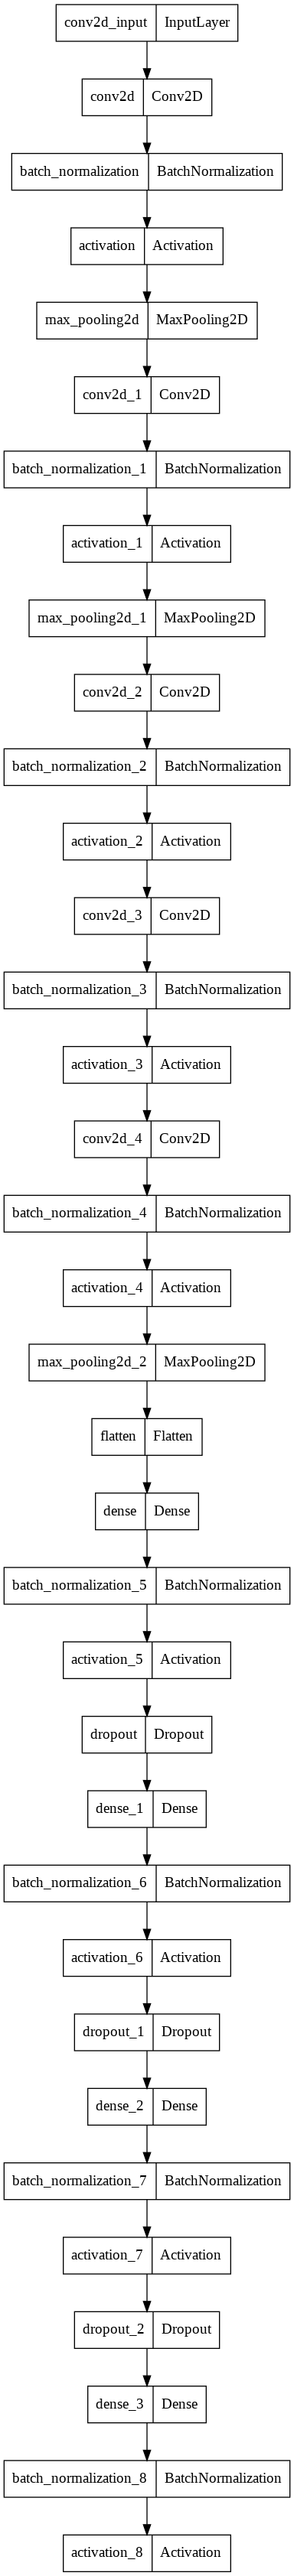

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x=train_dataset,
          epochs=10,  
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=None)

Epoch 1/10
179/179 [==============================] - 15s 61ms/step - loss: 3.0381 - accuracy: 0.0882 - val_loss: 2.9868 - val_accuracy: 0.0928
Epoch 2/10
179/179 [==============================] - 10s 55ms/step - loss: 2.8377 - accuracy: 0.1092 - val_loss: 2.8840 - val_accuracy: 0.1340
Epoch 3/10
179/179 [==============================] - 10s 57ms/step - loss: 2.7945 - accuracy: 0.1204 - val_loss: 2.6759 - val_accuracy: 0.1546
Epoch 4/10
179/179 [==============================] - 10s 56ms/step - loss: 2.6924 - accuracy: 0.1415 - val_loss: 2.6466 - val_accuracy: 0.1959
Epoch 5/10
179/179 [==============================] - 10s 56ms/step - loss: 2.6309 - accuracy: 0.1786 - val_loss: 2.5725 - val_accuracy: 0.1856
Epoch 6/10
179/179 [==============================] - 10s 57ms/step - loss: 2.6224 - accuracy: 0.1786 - val_loss: 2.5283 - val_accuracy: 0.1649
Epoch 7/10
179/179 [==============================] - 11s 60ms/step - loss: 2.6081 - accuracy: 0.1863 - val_loss: 2.6125 - val_accuracy:

In [ ]:
test_file_names = test_gen.filenames
predictions = model.predict_generator(test_dataset, len(test_file_names))

### 2. VGG16

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape=(img_h, img_w, img_ch), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=20, activation="softmax")) 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                  

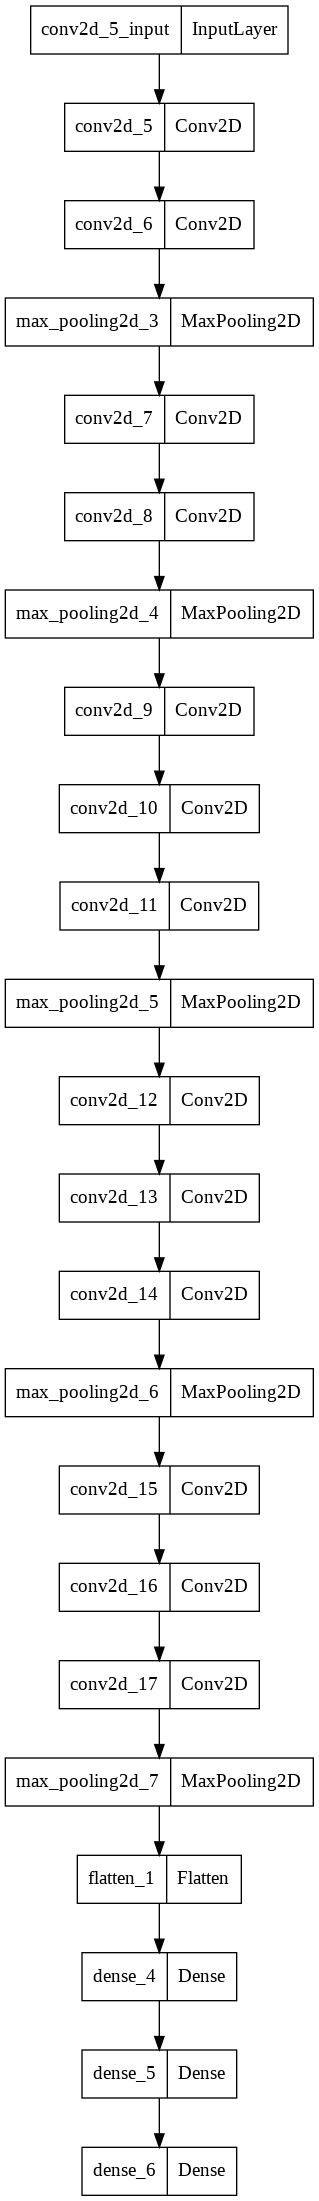

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x=train_dataset,
          epochs=10,  
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=None)

Epoch 1/10
179/179 [==============================] - 15s 75ms/step - loss: 3.0026 - accuracy: 0.0532 - val_loss: 2.9740 - val_accuracy: 0.0722
Epoch 2/10
179/179 [==============================] - 13s 70ms/step - loss: 2.9844 - accuracy: 0.0616 - val_loss: 2.9740 - val_accuracy: 0.0722
Epoch 3/10
179/179 [==============================] - 13s 70ms/step - loss: 2.9831 - accuracy: 0.0595 - val_loss: 2.9673 - val_accuracy: 0.0722
Epoch 4/10
179/179 [==============================] - 13s 71ms/step - loss: 2.9822 - accuracy: 0.0623 - val_loss: 2.9681 - val_accuracy: 0.0722
Epoch 5/10
179/179 [==============================] - 12s 69ms/step - loss: 2.9816 - accuracy: 0.0581 - val_loss: 2.9670 - val_accuracy: 0.0722
Epoch 6/10
179/179 [==============================] - 12s 69ms/step - loss: 2.9812 - accuracy: 0.0511 - val_loss: 2.9719 - val_accuracy: 0.0722
Epoch 7/10
179/179 [==============================] - 12s 69ms/step - loss: 2.9811 - accuracy: 0.0567 - val_loss: 2.9667 - val_accuracy:

In [ ]:
test_file_names = test_gen.filenames
predictions = model.predict_generator(test_dataset, len(test_file_names))

### 2.GoogLeNet:
1 is subtracted from all strides. Output is adjusted for 20 classes. In extera networks the first dense layer reduces from 1024 to 30.

In [ ]:
from tensorflow.keras.layers import Input, concatenate

In [ ]:
def Inception_block(input_layer, nf1, nf21, nf23, nf31, nf35, nf4): 
  stream1 = Conv2D(filters=nf1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  stream2 = Conv2D(filters = nf21, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  stream2 = Conv2D(filters = nf23, kernel_size = (3,3), padding = 'same', activation = 'relu')(stream2)
  stream3 = Conv2D(filters = nf31, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  stream3 = Conv2D(filters = nf35, kernel_size = (5,5), padding = 'same', activation = 'relu')(stream3)
  stream4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  stream4 = Conv2D(filters = nf4, kernel_size = (1,1), padding = 'same', activation = 'relu')(stream4)
  output_layer = concatenate([stream1, stream2, stream3, stream4], axis = -1)

  return output_layer

In [ ]:
def GoogLeNet():
  input_layer = Input(shape = (img_h, img_w, img_ch))
  x = Conv2D(filters = 64, kernel_size = (7,7), strides = 1, padding = 'valid', activation = 'relu')(input_layer)
  x = MaxPooling2D(pool_size = (3,3), strides = 1)(x)
  x = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
  x = MaxPooling2D(pool_size= (3,3), strides = 1)(x)
  x = Inception_block(x, nf1 = 64, nf21 = 96, nf23 = 128, nf31 = 16, nf35 = 32, nf4 = 32)
  x = Inception_block(x, nf1 = 128, nf21 = 128, nf23 = 192, nf31 = 32, nf35 = 96, nf4 = 64)
  x = MaxPooling2D(pool_size= (3,3), strides = 1)(x)
  x = Inception_block(x, nf1 = 192, nf21 = 96, nf23 = 208, nf31 = 16, nf35 = 48, nf4 = 64)

  x0 = AveragePooling2D(pool_size = (5,5), strides = 2)(x)
  x0 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(x0)
  x0 = Flatten()(x0)
  x0 = Dense(30, activation = 'relu')(x0)
  x0 = Dropout(0.7)(x0)
  x0 = Dense(20, activation = 'softmax')(x0)

  x = Inception_block(x, nf1 = 160, nf21 = 112, nf23 = 224, nf31 = 24, nf35 = 64, nf4 = 64)
  x = Inception_block(x, nf1 = 128, nf21 = 128, nf23 = 256, nf31 = 24, nf35 = 64, nf4 = 64)
  x = Inception_block(x, nf1 = 112, nf21 = 144, nf23 = 288, nf31 = 32, nf35 = 64, nf4 = 64)

  x1 = AveragePooling2D(pool_size = (5,5), strides = 2)(x)
  x1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(x1)
  x1 = Flatten()(x1)
  x1 = Dense(30, activation = 'relu')(x1)
  x1 = Dropout(0.7)(x1)
  x1 = Dense(20, activation = 'softmax')(x1)
  
  x = Inception_block(x, nf1 = 256, nf21 = 160, nf23 = 320, nf31 = 32, nf35 = 128, nf4 = 128)
  x = MaxPooling2D(pool_size = (3,3), strides = 1)(x)
  x = Inception_block(x, nf1 = 256, nf21 = 160, nf23 = 320, nf31 = 32, nf35 = 128, nf4 = 128)
  x = Inception_block(x, nf1 = 384, nf21 = 192, nf23 = 384, nf31 = 48, nf35 = 128, nf4 = 128)
  x = GlobalAveragePooling2D(name = 'GAPL')(x) 
  x = Dropout(0.4)(x)
  x = Dense(20, activation = 'softmax')(x)
  
  model = Model(input_layer, [x, x0, x1], name = 'GoogLeNet')

  return model

In [ ]:
model = GoogLeNet()

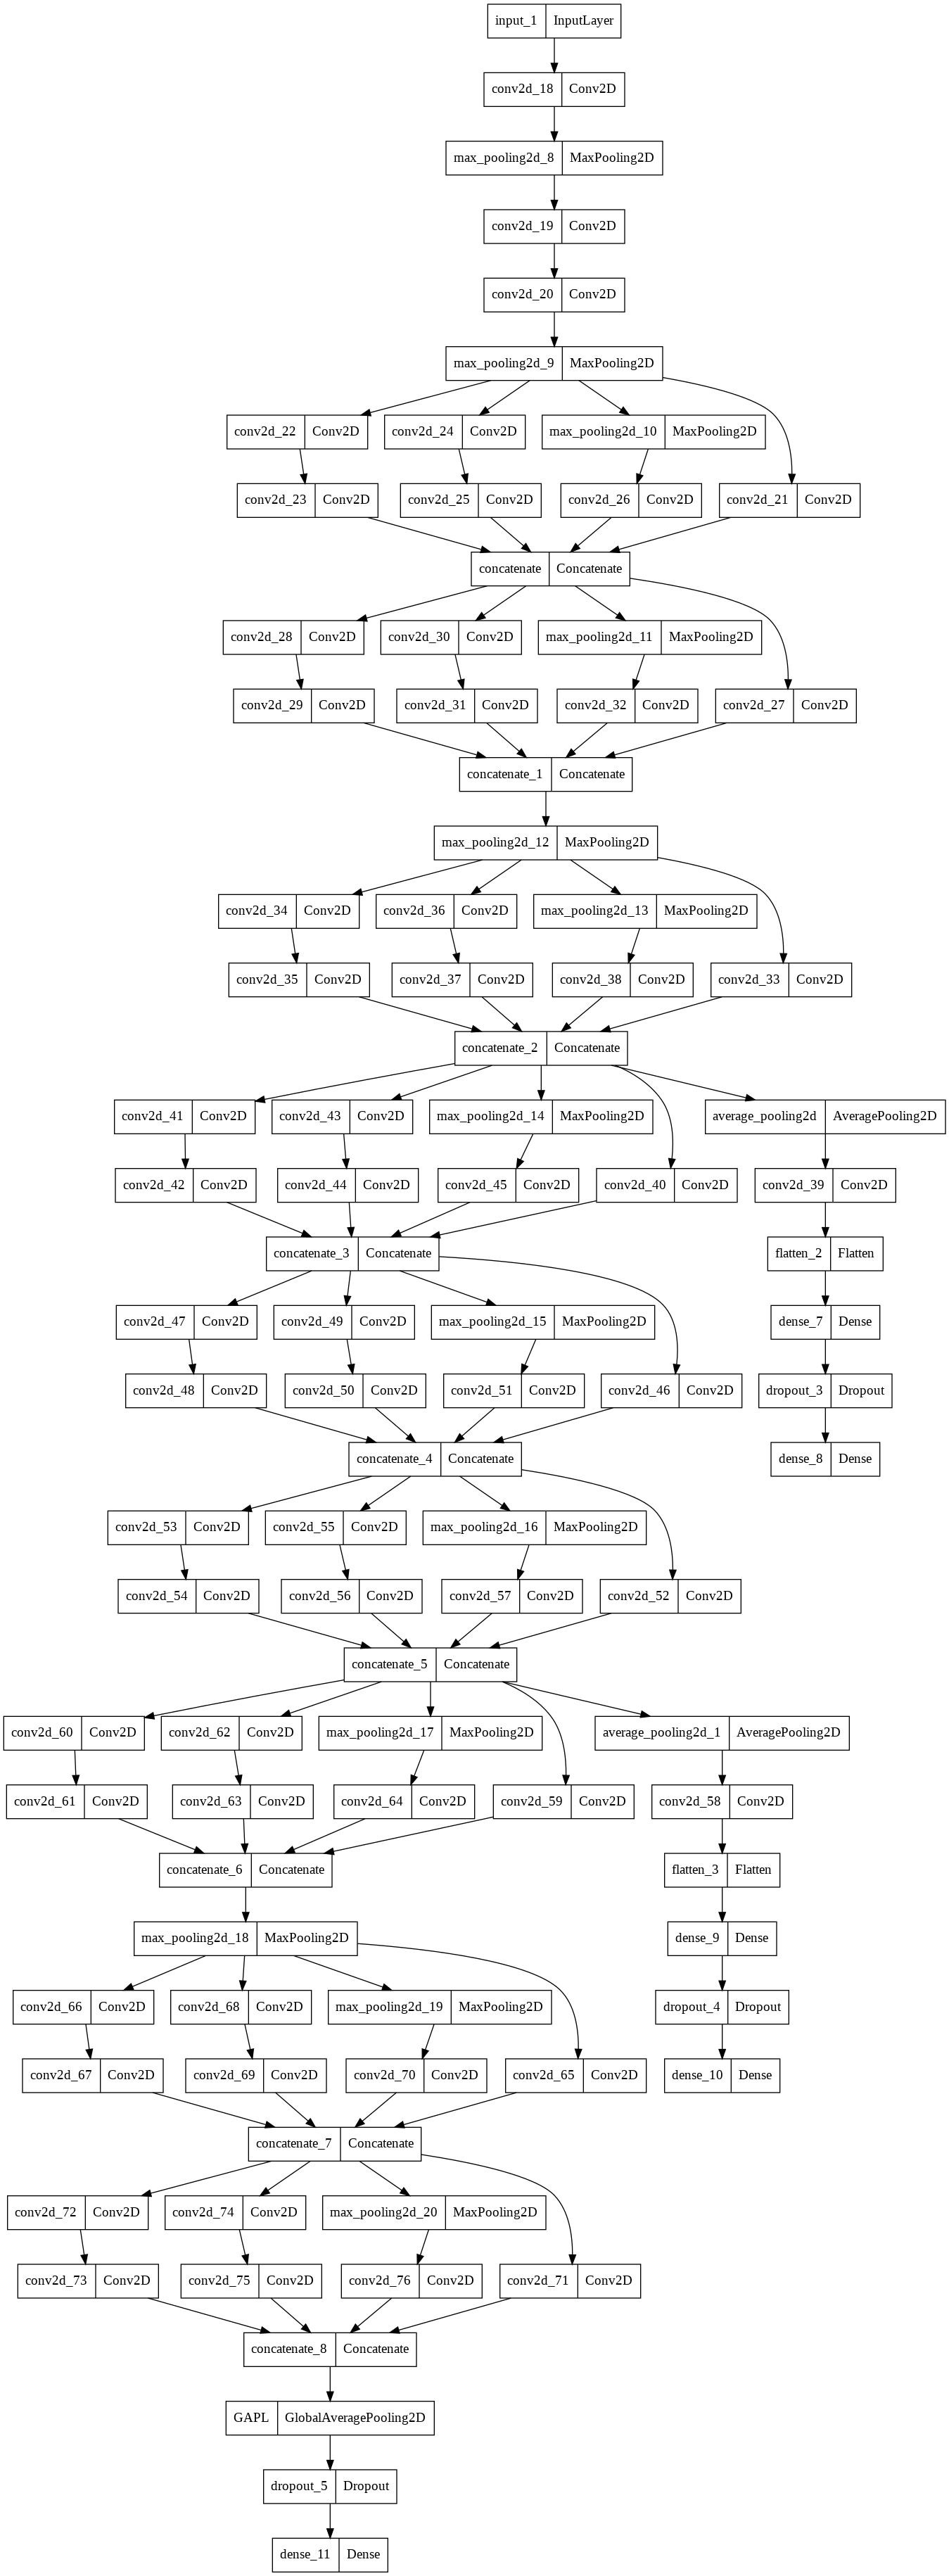

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 26, 26, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 24, 24, 64)  0           ['conv2d_18[0][0]']              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 24, 24, 64)   4160        ['max_pooling2d_8[0][0]']        
                                                                                          

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x=train_dataset,
          epochs=10,  
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=None)

Epoch 1/10
179/179 [==============================] - 27s 118ms/step - loss: 8.9864 - dense_11_loss: 2.9938 - dense_8_loss: 2.9962 - dense_10_loss: 2.9963 - dense_11_accuracy: 0.0490 - dense_8_accuracy: 0.0567 - dense_10_accuracy: 0.0672 - val_loss: 8.9546 - val_dense_11_loss: 2.9747 - val_dense_8_loss: 2.9896 - val_dense_10_loss: 2.9903 - val_dense_11_accuracy: 0.0722 - val_dense_8_accuracy: 0.0722 - val_dense_10_accuracy: 0.0722
Epoch 2/10
179/179 [==============================] - 16s 91ms/step - loss: 8.9690 - dense_11_loss: 2.9860 - dense_8_loss: 2.9918 - dense_10_loss: 2.9912 - dense_11_accuracy: 0.0630 - dense_8_accuracy: 0.0553 - dense_10_accuracy: 0.0637 - val_loss: 8.9482 - val_dense_11_loss: 2.9760 - val_dense_8_loss: 2.9865 - val_dense_10_loss: 2.9857 - val_dense_11_accuracy: 0.0722 - val_dense_8_accuracy: 0.0722 - val_dense_10_accuracy: 0.0722
Epoch 3/10
179/179 [==============================] - 16s 92ms/step - loss: 8.9597 - dense_11_loss: 2.9838 - dense_8_loss: 2.9883 -

In [ ]:
test_file_names = test_gen.filenames
predictions = model.predict_generator(test_dataset, len(test_file_names))

### 4. ResNet
Keeping stride below (3,3)

In [ ]:
from keras import backend as K
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import add
from keras.regularizers import l2

In [6]:
class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False,
                        reg=0.0001, bnEps=2e-5, bnMom=0.9):
      """
      data: input to the residual module.
      K: number of filters that will be learned by the final
       CONV layer (the first two CONV layers will learn K/4 filters).
      stride: controls the stride of the convolution (will help us reduce
       spatial dimensions without using max pooling).
      chanDim: defines the axis which will perform batch normalization.
      red: will control whether we are reducing spatial dimensions (True) or
       not (False) as not all residual modules will reduce dimensions of our
       spatial volume.
      reg: applies regularization strength for all CONV layers in
        the residual module.
      bnEps: controls the Ɛ responsible for avoiding “division by zero” errors
       when normalizing inputs.
      bnMom: controls the momentum for the moving average
      """
      # the shortcut branch of the ResNet module should be
	    # initialize as the input (identity) data
      shortcut = data
      # the first block of the ResNet module are the 1x1 CONVs
      bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
      act1 = Activation("relu")(bn1)
      conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False, 
                    kernel_regularizer=l2(reg))(act1)
      # the second block of the ResNet module are the 3x3 CONVs
      bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
      act2 = Activation("relu")(bn2)
      conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same",
                    use_bias=False, kernel_regularizer=l2(reg))(act2)
      # the third block of the ResNet module is another set of 1x1 CONVs
      bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv2)
      act3 = Activation("relu")(bn3)
      conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)
   
	    # if we are to reduce the spatial size, apply a CONV layer to the shortcut
      if red:
        shortcut= Conv2D(K, (1, 1), strides=stride, use_bias=False, 
                         kernel_regularizer=l2(reg))(act1) 

      # add together the shortcut and the final CONV
      x = add([conv3, shortcut])

      # return the addition as the output of the ResNet module
      return x

    @staticmethod
    def build(width, height, depth, classes, stages, filters, 
	        reg=0.0001, bnEps=2e-5, bnMom=0.9):
      
      # initialize the input shape to be "channels last" and the
	    # channels dimension itself
      inputShape = (height, width, depth)
      chanDim = -1

	    # if we are using "channels first", update the input shape
	    # and channels dimension
      if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
        
      # set the input and apply BN
      inputs = Input(shape=inputShape)
      x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                             momentum=bnMom)(inputs)
      # apply CONV => BN => ACT => POOL to reduce spatial size
      x = Conv2D(filters[0], (3, 3), use_bias=False,
                 padding="same", kernel_regularizer=l2(reg))(x)
      x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                             momentum=bnMom)(x)
      x = Activation("relu")(x)
      x = ZeroPadding2D((1, 1))(x)
      x = MaxPooling2D((3, 3), strides=(2, 2))(x)
      
      # loop over the number of stages
      for i in range(0, len(stages)):
        # initialize the stride, then apply a residual module
        # used to reduce the spatial size of the input volume
        stride = (1, 1) if i == 0 else (2, 2)
        x = ResNet.residual_module(x, filters[i + 1], stride,
                                   chanDim, red=True, bnEps=bnEps, bnMom=bnMom)
        # loop over the number of layers in the stage
        for j in range(0, stages[i] - 1):
          # apply a ResNet module
          x = ResNet.residual_module(x, filters[i + 1],
                                     (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
      # apply BN => ACT => POOL
      x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                             momentum=bnMom)(x)
      x = Activation("relu")(x)
      x = AveragePooling2D((3, 3))(x)
      
      # softmax classifier
      x = Flatten()(x)
      x = Dense(classes, kernel_regularizer=l2(reg))(x)
      x = Activation("softmax")(x)
      
      # create the model
      model = Model(inputs, x, name="resnet")
      
      # return the constructed network architecture
      return model


In [ ]:
stages = [3, 4, 6]
filters = [64, 128, 256, 512]
model = ResNet.build(img_h, img_w, img_ch, 20, stages, filters)

In [ ]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, 32, 32, 3)   12          ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_163 (Conv2D)            (None, 32, 32, 64)   1728        ['batch_normalization_94[0][0]'] 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 32, 32, 64)  256         ['conv2d_163[0][0]']        

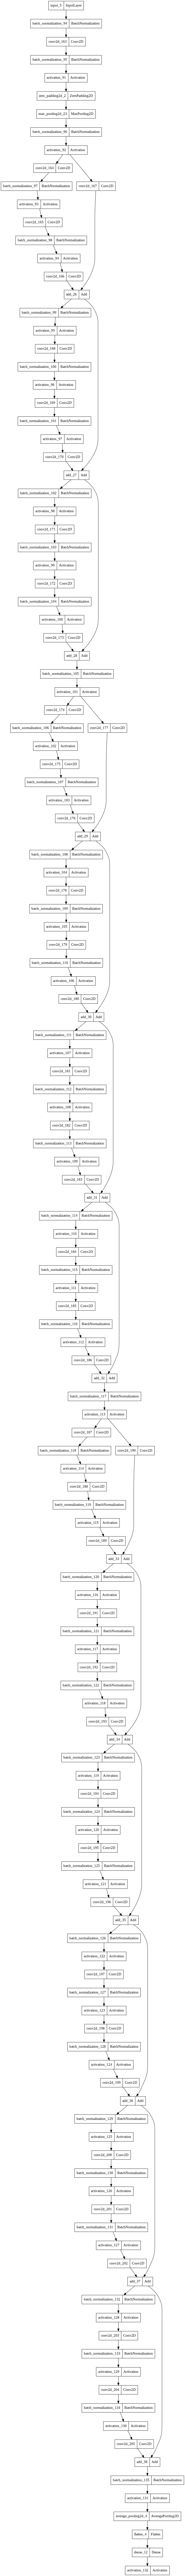

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x=train_dataset,
          epochs=10,  
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=None)

Epoch 1/10
179/179 [==============================] - 20s 85ms/step - loss: 3.4120 - accuracy: 0.1246 - val_loss: 3.2614 - val_accuracy: 0.1443
Epoch 2/10
179/179 [==============================] - 12s 65ms/step - loss: 3.1906 - accuracy: 0.1926 - val_loss: 2.9637 - val_accuracy: 0.1753
Epoch 3/10
179/179 [==============================] - 12s 68ms/step - loss: 3.1017 - accuracy: 0.2003 - val_loss: 2.9366 - val_accuracy: 0.2680
Epoch 4/10
179/179 [==============================] - 12s 67ms/step - loss: 2.9779 - accuracy: 0.2360 - val_loss: 3.0738 - val_accuracy: 0.2062
Epoch 5/10
179/179 [==============================] - 12s 66ms/step - loss: 2.9059 - accuracy: 0.2479 - val_loss: 2.9359 - val_accuracy: 0.2268
Epoch 6/10
179/179 [==============================] - 11s 64ms/step - loss: 2.8444 - accuracy: 0.2752 - val_loss: 2.8712 - val_accuracy: 0.2990
Epoch 7/10
179/179 [==============================] - 12s 65ms/step - loss: 2.7828 - accuracy: 0.2773 - val_loss: 2.8620 - val_accuracy:

In [ ]:
test_file_names = test_gen.filenames
predictions = model.predict_generator(test_dataset, len(test_file_names))

<ipython-input-54-36489d487419>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_dataset, len(test_file_names))
